In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

from utils import utils
import deformation.losses as def_losses


In [4]:
def get_exp_path(exp_name):
    if os.path.exists(os.path.join("out",exp_name)):
        return exp_name
    
    if exp_name == "latest":
        exp_paths = []
        for root, dirs, files in os.walk("out"):
            for d in dirs:
                if "--" in d and len(os.path.join(root,d).split('/'))==2:
                    exp_paths.append(d)
        return sorted(exp_paths)[-1]
    
    exp_path = []
    for root, dirs, files in os.walk("out"):
        for d in dirs:
            if exp_name == d[21:] and len(os.path.join(root,d).split('/'))==2:
                exp_path.append(d)
    if len(exp_path) > 1:
        print(exp_path)
        raise Exception("multiple experiments with that name")
    elif len(exp_path) == 0:
        raise Exception("Couldn't find any matching experiments")
    else:
        return exp_path[0]

In [5]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/default.yaml"
cfg = utils.load_config(cfg_path, "configs/default.yaml")

# Show Adversarial Training Info

out/2020_09_17--11_49_23_job7
False


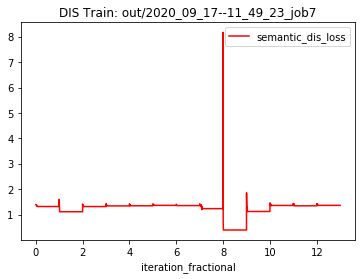

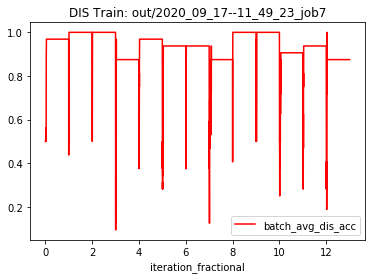

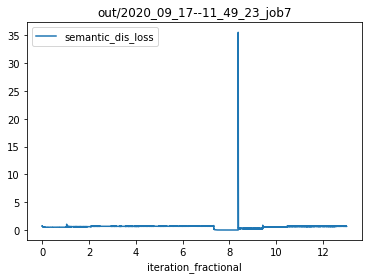

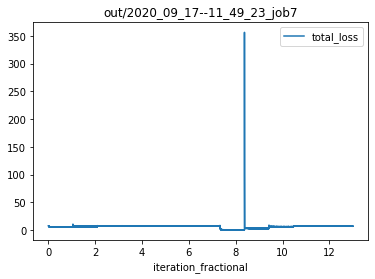

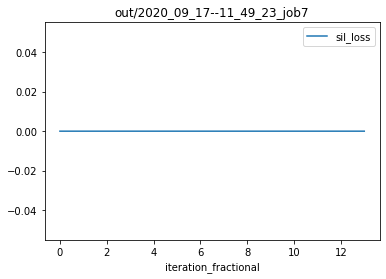

In [23]:
#n="latest"
n="job7"
saved_model_path = "out/{}".format(get_exp_path(n))
print(saved_model_path)


# show training plots
training_info = pickle.load(open(os.path.join(saved_model_path, "training_df.p"), "rb"))

# showing discriminator plots
semantic_dis_training_df = training_info["semantic_dis"]
if not semantic_dis_training_df.empty:
    # adding extra column for fracitional iteration
    iteration_fractional = np.linspace(0, max(semantic_dis_training_df['iteration'])+1, len(semantic_dis_training_df)+1)[:-1]
    semantic_dis_training_df["iteration_fractional"] = iteration_fractional
    
    print(semantic_dis_training_df.isnull().values.any())
    
    #pd.set_option('display.max_rows', None)  
    #display(semantic_dis_training_df)
    semantic_dis_training_df.plot.line(x="iteration_fractional", y="semantic_dis_loss", title="DIS Train: " + saved_model_path, color='r')
    semantic_dis_training_df.plot.line(x="iteration_fractional", y="batch_avg_dis_acc", title="DIS Train: " + saved_model_path, color='r')

# showing generator (deformation net) plots
deform_gen_training_df = training_info["deform_net_gen"]
if not deform_gen_training_df.empty:
    iteration_fractional = np.linspace(0, max(deform_gen_training_df['iteration'])+1, len(deform_gen_training_df)+1)[:-1]
    deform_gen_training_df["iteration_fractional"] = iteration_fractional
    #display(deform_gen_training_df)

    deform_gen_training_df.plot.line(x="iteration_fractional", y="semantic_dis_loss", title=saved_model_path)
    deform_gen_training_df.plot.line(x="iteration_fractional", y="total_loss", title=saved_model_path)
    deform_gen_training_df.plot.line(x="iteration_fractional", y="sil_loss", title=saved_model_path)

# Show Adversarial Training Results

In [21]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, only_show_instances=[], num_novel_view=3):
    input_dir_img = cfg['dataset']['input_dir_img']
    input_dir_mesh = cfg['dataset']['input_dir_mesh']
    
    cached_pred_poses = pickle.load(open(cfg['semantic_dis_training']["input_dir_pose"], "rb"))
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in sorted(processed_paths_dict[instance_name], key= lambda x : int(str(x).split('/')[-2].replace("eval_", ""))):
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)

                # rendering original and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
                mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
                mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)
                
                # rendering processed mesh at poses other than the predicted pose
                novel_view_renders = []
                for i in range(num_novel_view):
                    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim+ ((i+1)*45))
                    novel_view_renders.append(utils.render_mesh(mesh_processed, R, T, device))

                # visualizing
                print(processed_mesh_path)
                fig, ax = plt.subplots(nrows=1, ncols=3+num_novel_view, squeeze=False, figsize=(15,5))
                ax[0][0].imshow(input_image)
                ax[0][0].xaxis.set_visible(False)
                ax[0][0].yaxis.set_visible(False)

                ax[0][1].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
                ax[0][1].xaxis.set_visible(False)
                ax[0][1].yaxis.set_visible(False)

                ax[0][2].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
                ax[0][2].xaxis.set_visible(False)
                ax[0][2].yaxis.set_visible(False)
                
                for i in range(num_novel_view):
                    ax[0][2+i+1].imshow(novel_view_renders[i][0, ..., :3].cpu().numpy())
                    ax[0][2+i+1].xaxis.set_visible(False)
                    ax[0][2+i+1].yaxis.set_visible(False)
                plt.pause(0.05)

['eval_0', 'eval_5', 'eval_10']
Latest eval dir: out/2020_09_17--11_49_23_job7/eval_10

out/2020_09_17--11_49_23_job7/eval_10/3729.obj


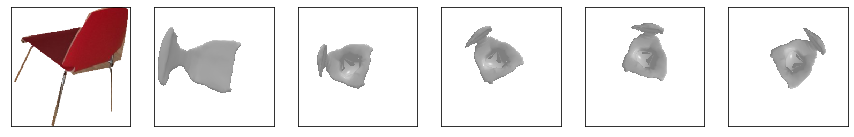

out/2020_09_17--11_49_23_job7/eval_10/3018.obj


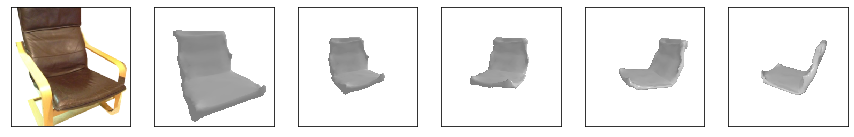

out/2020_09_17--11_49_23_job7/eval_10/0225.obj


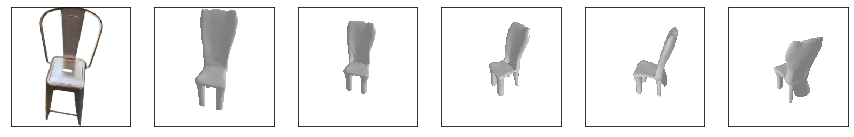

out/2020_09_17--11_49_23_job7/eval_10/2642.obj


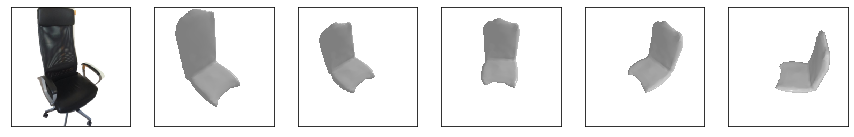

out/2020_09_17--11_49_23_job7/eval_10/1598.obj


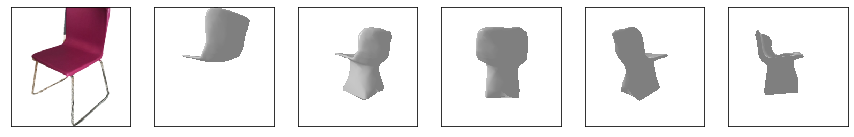

out/2020_09_17--11_49_23_job7/eval_10/1869.obj


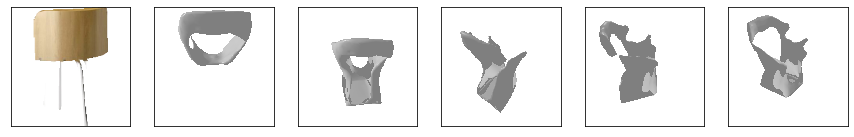

out/2020_09_17--11_49_23_job7/eval_10/1752.obj


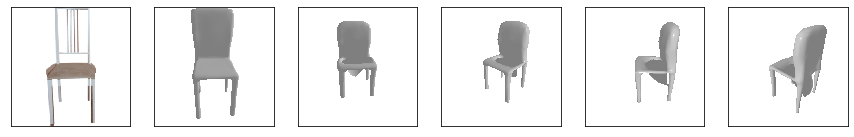

out/2020_09_17--11_49_23_job7/eval_10/2047.obj


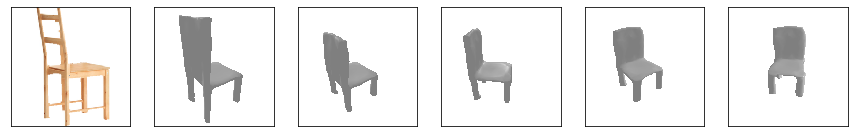

out/2020_09_17--11_49_23_job7/eval_10/0701.obj


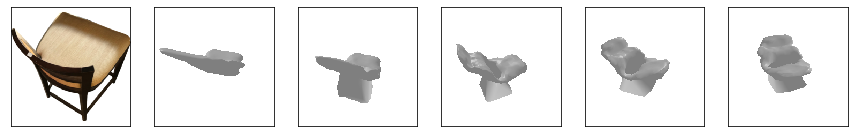

out/2020_09_17--11_49_23_job7/eval_10/3314.obj


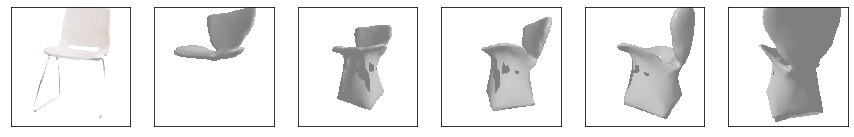

In [24]:
# show all latest meshes
eval_dirs = []
for root, dirs, files in os.walk(saved_model_path):
    for d in dirs:
        if "eval_" in d:
            eval_dirs.append(d)
eval_dirs = sorted(eval_dirs, key= lambda x: int(x.replace("eval_", "")))
print(eval_dirs)
latest_eval_dir = os.path.join(saved_model_path, eval_dirs[-1])
print("Latest eval dir: {}\n".format(latest_eval_dir))
show_meshes(cfg, device, latest_eval_dir)

out/2020_09_15--22_52_04_job9/eval_0/3018.obj


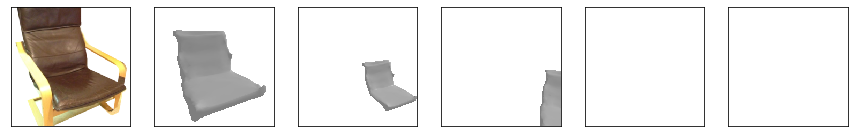

out/2020_09_15--22_52_04_job9/eval_5/3018.obj


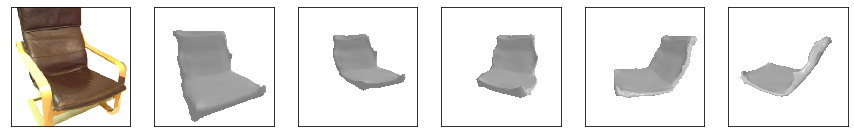

out/2020_09_15--22_52_04_job9/eval_10/3018.obj


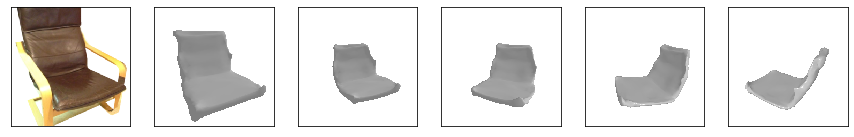

out/2020_09_15--22_52_04_job9/eval_15/3018.obj


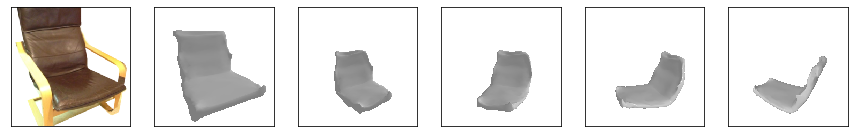

out/2020_09_15--22_52_04_job9/eval_20/3018.obj


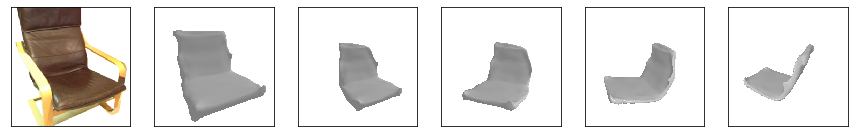

out/2020_09_15--22_52_04_job9/eval_25/3018.obj


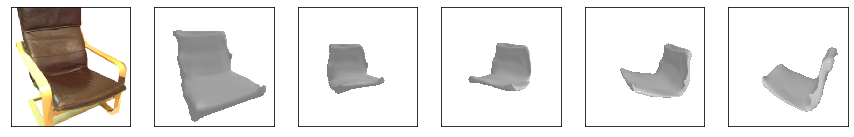

out/2020_09_15--22_52_04_job9/eval_30/3018.obj


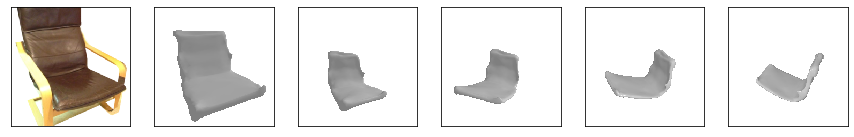

out/2020_09_15--22_52_04_job9/eval_35/3018.obj


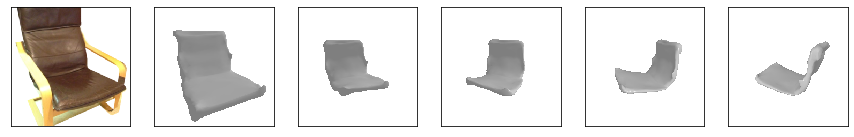

out/2020_09_15--22_52_04_job9/eval_40/3018.obj


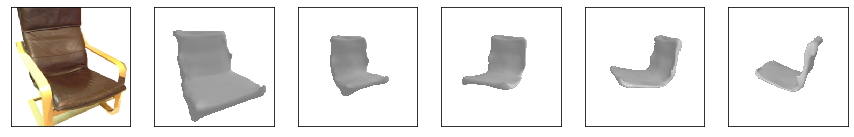

out/2020_09_15--22_52_04_job9/eval_45/3018.obj


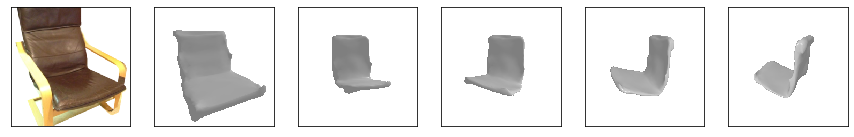

out/2020_09_15--22_52_04_job9/eval_50/3018.obj


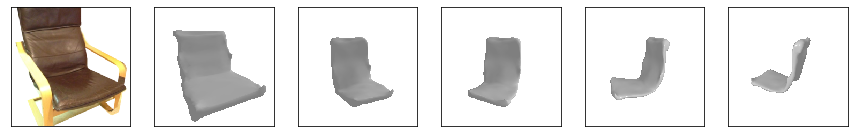

out/2020_09_15--22_52_04_job9/eval_55/3018.obj


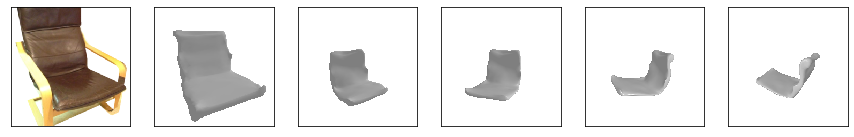

out/2020_09_15--22_52_04_job9/eval_60/3018.obj


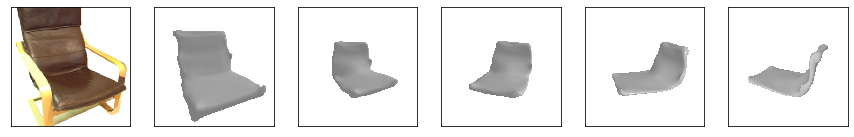

out/2020_09_15--22_52_04_job9/eval_65/3018.obj


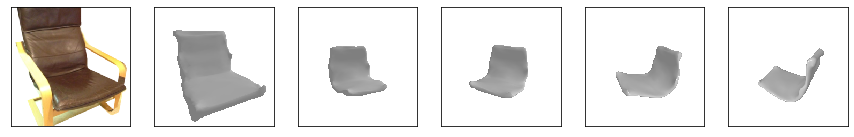

out/2020_09_15--22_52_04_job9/eval_70/3018.obj


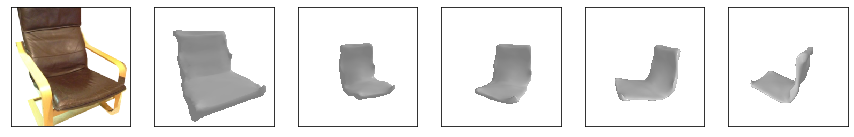

out/2020_09_15--22_52_04_job9/eval_75/3018.obj


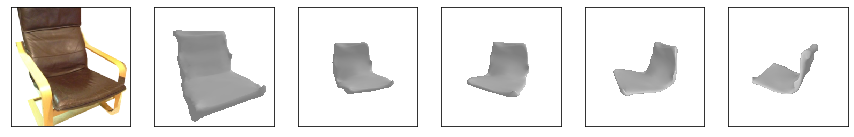

out/2020_09_15--22_52_04_job9/eval_80/3018.obj


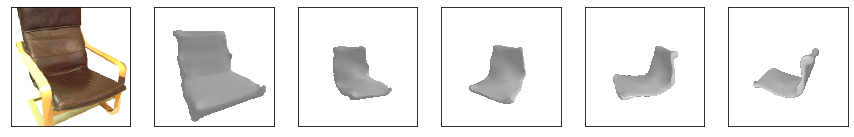

out/2020_09_15--22_52_04_job9/eval_85/3018.obj


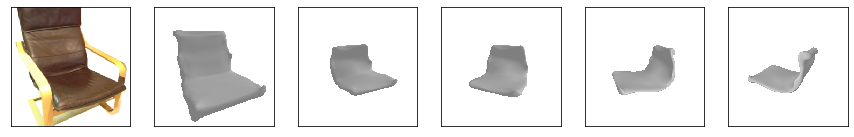

In [10]:
# show a mesh throughout iterations
#instance_to_show = "2047"
#instance_to_show = "1752"
instance_to_show = "3018"
#instance_to_show = "1598"
#instance_to_show = "3314"
show_meshes(cfg, device, saved_model_path, [instance_to_show])